# Installing dependencies

In [31]:
! pip install 'scikit-learn==0.23.1'

As this dataset is heavy both in number of columns and in number of registers, we are going to create a complete pipeline for preprocessing and we will save preprocessed versions of the datasets.

In [1]:
import pandas as pd
import numpy as np
import pylab as plt

%matplotlib inline

In [ ]:
path_customers = ""../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv"

In [2]:
customers = pd.read_csv(path_customers, sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
customers.shape

(191652, 369)

In [4]:
n_rows = customers.shape[0]

Let's see what is going on in these columns that produce warnings (18 and 19)

Column 18

In [5]:
customers.columns[18]

'CAMEO_DEUG_2015'

In [6]:
customers.iloc[:, 18].value_counts(dropna=False)

NaN    50428
2      17574
4      16458
6      14008
3      13585
1      12498
8       9716
5       8624
7       7878
2.0     5910
4.0     5606
3.0     4805
9       4731
6.0     4709
1.0     4280
8.0     3333
5.0     3042
7.0     2680
9.0     1661
X        126
Name: CAMEO_DEUG_2015, dtype: int64

From the document "DIAS Attributes - Values 2017.xlsx" we find that X is a non-accepted value

Column 19

In [7]:
customers.columns[19]

'CAMEO_INTL_2015'

In [8]:
customers.iloc[:, 19].value_counts(dropna=False)

NaN     50428
14      14708
24      13301
41       8461
43       7158
25       6900
15       6845
51       5987
13       5728
22       5566
14.0     4939
24.0     4504
23       4276
34       3945
45       3936
54       3537
41.0     2859
55       2794
12       2791
43.0     2476
25.0     2472
15.0     2372
44       2144
51.0     2126
31       2050
13.0     1955
22.0     1941
35       1741
23.0     1494
34.0     1423
45.0     1352
54.0     1258
32       1256
33       1178
12.0      924
55.0      920
52        770
44.0      688
31.0      681
35.0      553
32.0      440
33.0      396
52.0      253
XX        126
Name: CAMEO_INTL_2015, dtype: int64

Again, XX is not an accepted value.

# Steps

We will divide the preprocess work into the following steps:

1. Set Data Types
1. Remove non-accepted values (quality issues)
1. Deal with NULL values
1. Numerical values: remove highly correlated columns using Pearson correlation
1. Numerical values: remove outliers using a modified version of Tukey's fence
1. Categorical values: remove low variance features and those with high cardinality

## 1. Set Data Types

Create a dictionary column name <-> type

In [9]:
path2attributes = "DIAS Attributes - Values 2017.xlsx"
header_start = 1 
attributes = pd.read_excel(path2attributes, header=header_start)

In [10]:
attributes.head(10)

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,NaN,NaN,0,no classification possible
NaN,NaN,NaN,1,passive elderly
NaN,NaN,NaN,2,cultural elderly
NaN,NaN,NaN,3,experience-driven elderly
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
NaN,NaN,NaN,1,< 30 years
NaN,NaN,NaN,2,30 - 45 years
NaN,NaN,NaN,3,46 - 60 years
NaN,NaN,NaN,4,> 60 years


In [11]:
attributes.reset_index(drop=True, inplace=True)
attributes.columns = [elem.lower() for elem in attributes.columns]

In [12]:
attributes.head(10)

,attribute,description,value,meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [13]:
next(attributes.itertuples())

Pandas(Index=0, attribute='AGER_TYP', description='best-ager typology', value=-1, meaning='unknown')

Let's format the dataframe into something more suitable to our task, removing NANs and grouping intervals and values into lists.

In [14]:
attributes_preproc = []
values = []
meaning = []
row_preproc = {}


for row in attributes.itertuples():
    attribute = row.attribute
    
    if not pd.isna(attribute):
        if row_preproc: # New attribute -> save previous data
            
            # Save
            row_preproc['values'] = values.copy()
            row_preproc['meaning'] = meaning.copy()
            attributes_preproc.append(row_preproc.copy())
            
            # Clear
            values.clear()
            meaning.clear()
            row_preproc.clear()

        row_preproc['attribute'] = row.attribute
        row_preproc['description'] = row.description
    
    values.append(row.value)
    meaning.append(row.meaning)

In [15]:
attributes_preproc_df = pd.DataFrame(attributes_preproc)
attributes_preproc_df.head()

,attribute,description,meaning,values
0,AGER_TYP,best-ager typology,"[unknown, no classification possible, passive ...","[-1, 0, 1, 2, 3]"
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[unknown, < 30 years, 30 - 45 years, 46 - 60 y...","[-1, 0, 1, 2, 3, 4, 9]"
2,ALTER_HH,main age within the household,"[unknown / no main age detectable, 01.01.1895 ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,ANREDE_KZ,gender,"[unknown, male, female]","[-1, 0, 1, 2]"
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,[numeric value (typically coded from 1-10)],[…]


In [16]:
def get_type(row):
    if row['meaning'][0].startswith("numeric value"):
        return 'float'
    else:
        return 'category'

attributes_preproc_df['type'] = attributes_preproc_df.apply(get_type, axis=1)

In [17]:
attributes_preproc_df.head()

,attribute,description,meaning,values,type
0,AGER_TYP,best-ager typology,"[unknown, no classification possible, passive ...","[-1, 0, 1, 2, 3]",category
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[unknown, < 30 years, 30 - 45 years, 46 - 60 y...","[-1, 0, 1, 2, 3, 4, 9]",category
2,ALTER_HH,main age within the household,"[unknown / no main age detectable, 01.01.1895 ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",category
3,ANREDE_KZ,gender,"[unknown, male, female]","[-1, 0, 1, 2]",category
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,[numeric value (typically coded from 1-10)],[…],float


In [18]:
converter = dict(zip(attributes_preproc_df['attribute'], attributes_preproc_df['type']))

Apply data type conversion

In [19]:
not_present_cols = []
converted = 0

for col in customers.columns:
    
    if col in converter:
        customers[col] = customers[col].astype(converter[col])
        converted += 1
    else:
        not_present_cols.append(col)

print("Columns converted: ", converted)
print("Columns not in listed attributes: %i" % len(not_present_cols))
print(not_present_cols)

Columns converted:  271
Columns not in listed attributes: 98
['LNR', 'AKT_DAT_KL', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT', 'CAMEO_INTL_2015', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_MOBILE', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_REST', 'D19_VER

**Decission**: we are discarding those columns that are not present in the description

**Note**: 'LNR' column will be used in the 3rd part, the Kaggle challenge, thus we keep it for now

In [20]:
not_present_cols.remove("LNR")

In [21]:
customers2 = customers.drop(columns=not_present_cols)

## 2. Remove non-accepted values (quality issues)

We will only focus on categorical values in this step, because for the numeric case we have one dedicated step for dealing with outliers.

We will substitute non-accepted values by NANs. We will deal with NANs later.

In [22]:
checker_df = attributes_preproc_df[ attributes_preproc_df['type'] == 'category'][['attribute', 'values']]
checker_df.head()

,attribute,values
0,AGER_TYP,"[-1, 0, 1, 2, 3]"
1,ALTERSKATEGORIE_GROB,"[-1, 0, 1, 2, 3, 4, 9]"
2,ALTER_HH,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,ANREDE_KZ,"[-1, 0, 1, 2]"
8,BALLRAUM,"[-1, 1, 2, 3, 4, 5, 6, 7]"


In [23]:
checker = dict(zip(checker_df['attribute'], checker_df['values']))

In [24]:
columns_fixed = 0

for col in checker.keys():
    
    if col in customers2.columns:
        mask = ~ customers2[col].isin(checker[col] + [np.nan])
        
        if any(mask):
            customers2[col][mask] = np.nan
            columns_fixed += 1
        
print("Total columns fixed: ", columns_fixed)

Total columns fixed:  74


## 3. Deal with NULL values

In [25]:
total = np.prod(customers2.shape)
nulls = customers2.isna().sum().sum()
null_perc = 100*nulls/total

print("NULL percentage is %.2lf%%" % null_perc)

NULL percentage is 22.19%


In [26]:
(100*customers2.isna().sum()/len(customers2)) \
    .sort_values(ascending=False) \
    .head(10)

TITEL_KZ           98.793647
CAMEO_DEUG_2015    81.202388
KBA05_BAUMAX       57.153069
REGIOTYP           31.340137
KKK                31.340137
W_KEIT_KIND_HH     29.708534
KBA05_AUTOQUOT     29.696533
KBA05_MAXVORB      29.696012
KBA05_MOTOR        29.696012
KBA05_MOD8         29.696012
dtype: float64

In [27]:
print("Number of columns: ", len(customers2.columns))

Number of columns:  272


In [28]:
nulls_by_column = 100*customers2.isna().sum()/len(customers2)

threshold = [10, 20, 25, 30, 35, 40]
for th in threshold:

    nulls_by_column_gt_thr = nulls_by_column[nulls_by_column > th]
    print("Number of columns with more than %d%% of NULLs: %d" % (th, len(nulls_by_column_gt_thr)))

Number of columns with more than 10% of NULLs: 213
Number of columns with more than 20% of NULLs: 213
Number of columns with more than 25% of NULLs: 204
Number of columns with more than 30% of NULLs: 5
Number of columns with more than 35% of NULLs: 3
Number of columns with more than 40% of NULLs: 3


We will set the cut-off point to be 30%. Those columns with more than 30% will be rejected. The remaining will be imputed.

### Prunning

e.g. removing those columns that don't overcome the cut-off point.

In [29]:
th=30
nulls_by_column_gt_thr = nulls_by_column[nulls_by_column > th]

In [30]:
customers3 = customers2.drop(columns=list(nulls_by_column_gt_thr.index))

### Imputting

We will split the dataset into two: one that contains numerical variables and another one with the categorical ones.

In [32]:
from sklearn.impute import SimpleImputer

In [34]:
customers3.select_dtypes(include=np.number)

,LNR,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,GEBURTSJAHR,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR
0,9626,1.0,0.0,2.0,0.0,0.0,1201.0,1992.0
1,9628,NaN,NaN,3.0,0.0,0.0,NaN,NaN
2,143872,1.0,0.0,1.0,0.0,0.0,433.0,1992.0
3,143873,0.0,NaN,0.0,0.0,0.0,755.0,1992.0
4,143874,7.0,0.0,4.0,0.0,1960.0,513.0,1992.0
5,143888,1.0,0.0,2.0,0.0,0.0,1167.0,1992.0
6,143904,1.0,0.0,2.0,0.0,1942.0,1300.0,1992.0
7,143910,1.0,0.0,2.0,0.0,1938.0,481.0,1992.0
8,102160,74.0,2.0,1.0,0.0,1914.0,428.0,1994.0
9,102173,1.0,0.0,3.0,0.0,1959.0,1106.0,1997.0


In [35]:
imp_numeric = SimpleImputer(strategy="mean")
numeric_df = customers3.select_dtypes(include=np.number)
numeric_filled = pd.DataFrame(imp_numeric.fit_transform(numeric_df), columns=numeric_df.columns)

In [36]:
numeric_df.head()

,LNR,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,GEBURTSJAHR,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR
0,9626,1.0,0.0,2.0,0.0,0.0,1201.0,1992.0
1,9628,NaN,NaN,3.0,0.0,0.0,NaN,NaN
2,143872,1.0,0.0,1.0,0.0,0.0,433.0,1992.0
3,143873,0.0,NaN,0.0,0.0,0.0,755.0,1992.0
4,143874,7.0,0.0,4.0,0.0,1960.0,513.0,1992.0


In [37]:
numeric_filled.head()

,LNR,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,GEBURTSJAHR,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR
0,9626.0,1.000000,0.000000,2.0,0.0,0.0,1201.000000,1992.000000
1,9628.0,4.965863,0.067413,3.0,0.0,0.0,667.231216,1993.056659
2,143872.0,1.000000,0.000000,1.0,0.0,0.0,433.000000,1992.000000
3,143873.0,0.000000,0.067413,0.0,0.0,0.0,755.000000,1992.000000
4,143874.0,7.000000,0.000000,4.0,0.0,1960.0,513.000000,1992.000000


In [38]:
imp_categoric = SimpleImputer(strategy="most_frequent")
category_df = customers3.select_dtypes(include='category')
category_filled = pd.DataFrame(imp_categoric.fit_transform(category_df), columns=category_df.columns)

In [39]:
category_df.head()

,AGER_TYP,ALTER_HH,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2,10.0,3.0,1A,5.0,0,0,10,10,10,...,6,1,6,3,1,6.0,9.0,7.0,1,4
1,-1,11.0,NaN,NaN,NaN,0,1,6,10,10,...,3,1,7,3,1,NaN,9.0,NaN,1,4
2,-1,6.0,7.0,5D,2.0,0,0,10,10,10,...,2,1,3,1,2,6.0,9.0,2.0,2,4
3,1,8.0,7.0,4C,2.0,0,0,10,10,10,...,6,4,7,0,1,NaN,9.0,7.0,1,4
4,-1,20.0,3.0,7B,6.0,1,2,3,10,7,...,4,4,5,1,2,2.0,9.0,3.0,1,3


In [40]:
category_filled.head()

,AGER_TYP,ALTER_HH,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2,10,3,1A,5,0,0,10,10,10,...,6,1,6,3,1,6,9,7,1,4
1,-1,11,6,2D,6,0,1,6,10,10,...,3,1,7,3,1,6,9,3,1,4
2,-1,6,7,5D,2,0,0,10,10,10,...,2,1,3,1,2,6,9,2,2,4
3,1,8,7,4C,2,0,0,10,10,10,...,6,4,7,0,1,6,9,7,1,4
4,-1,20,3,7B,6,1,2,3,10,7,...,4,4,5,1,2,2,9,3,1,3


## 4. Numerical values: remove highly correlated columns using Pearson correlation

In [41]:
numeric_filled.head()

,LNR,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,GEBURTSJAHR,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR
0,9626.0,1.000000,0.000000,2.0,0.0,0.0,1201.000000,1992.000000
1,9628.0,4.965863,0.067413,3.0,0.0,0.0,667.231216,1993.056659
2,143872.0,1.000000,0.000000,1.0,0.0,0.0,433.000000,1992.000000
3,143873.0,0.000000,0.067413,0.0,0.0,0.0,755.000000,1992.000000
4,143874.0,7.000000,0.000000,4.0,0.0,1960.0,513.000000,1992.000000


In [42]:
import seaborn as sns

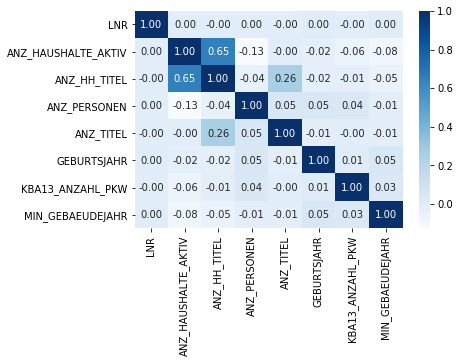

In [43]:
sns.heatmap(numeric_filled.corr(), annot=True, cmap="Blues", fmt=".2f")

There are not very high values, hence we will keep all the numerical features.

## 5. Numerical values: remove outliers using a modified version of Tukey's fence

While working with the data I realize this step could be very dangerous. As this dataset has a huge number of columns, I will not apply specific techniques to each one, as this would be very time consuming. Thus, I've made a trade-off between performance and time.

From my experience, I know some variables like amount (in transactions) which are heavily right-skewed could show a high number of outliers blindly applying Tukey's fence. The best approach could be to deal first with the skewness using a log transform and then apply Tukey's fence. More variables could show this behaviour, but as I'm not going to do this study one-by-one, it's better to don't remove outliers. At list at this iteration.

## 6. Categorical values: remove low variance features and those with high cardinality

In [44]:
category_filled.head()

,AGER_TYP,ALTER_HH,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2,10,3,1A,5,0,0,10,10,10,...,6,1,6,3,1,6,9,7,1,4
1,-1,11,6,2D,6,0,1,6,10,10,...,3,1,7,3,1,6,9,3,1,4
2,-1,6,7,5D,2,0,0,10,10,10,...,2,1,3,1,2,6,9,2,2,4
3,1,8,7,4C,2,0,0,10,10,10,...,6,4,7,0,1,6,9,7,1,4
4,-1,20,3,7B,6,1,2,3,10,7,...,4,4,5,1,2,2,9,3,1,3


We need to convert this dataset to numerical values to be able to filter by variance. A numerical encoding is the most convenient way.

In [45]:
from sklearn.preprocessing import OrdinalEncoder

In [50]:
ordinal_enc = OrdinalEncoder()
category_enc = ordinal_enc.fit_transform(category_filled)
category_enc = pd.DataFrame(category_enc, columns=category_filled.columns)

In [51]:
category_enc.head()

,AGER_TYP,ALTER_HH,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,3.0,9.0,2.0,0.0,4.0,0.0,0.0,9.0,9.0,9.0,...,5.0,0.0,5.0,4.0,1.0,5.0,8.0,6.0,0.0,3.0
1,0.0,10.0,5.0,8.0,5.0,0.0,1.0,5.0,9.0,9.0,...,2.0,0.0,6.0,4.0,1.0,5.0,8.0,3.0,0.0,3.0
2,0.0,5.0,6.0,21.0,1.0,0.0,0.0,9.0,9.0,9.0,...,1.0,0.0,2.0,2.0,2.0,5.0,8.0,2.0,1.0,3.0
3,2.0,7.0,6.0,15.0,1.0,0.0,0.0,9.0,9.0,9.0,...,5.0,3.0,6.0,1.0,1.0,5.0,8.0,6.0,0.0,3.0
4,0.0,19.0,2.0,31.0,5.0,1.0,2.0,2.0,9.0,6.0,...,3.0,3.0,4.0,2.0,2.0,1.0,8.0,3.0,0.0,2.0


In [52]:
from sklearn.feature_selection import VarianceThreshold

The threshold will be 80%. It will remove columns where more than 80% of the samples are constant.

In [53]:
selected = VarianceThreshold(threshold=(.8 * (1 - .8)))
selected = selected.fit(category_enc)

In [59]:
low_var_cols = list(category_enc.columns[ ~selected.get_support() ])
low_var_cols

['D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_ONLINE_DATUM',
 'D19_VERSI_ANZ_12',
 'KBA05_SEG6',
 'KBA13_KRSSEG_KLEIN',
 'NATIONALITAET_KZ',
 'OST_WEST_KZ']

Removing variables with high cardinality

In [60]:
max_cat_thr = 10
high_card_cols = []

for col in category_enc.columns:
    
    if len(category_enc[col].unique()) > max_cat_thr:
        high_card_cols.append(col)
        
print("Columns with more than %d different categories:" % max_cat_thr)
print(high_card_cols)
print("Nº columns: ", len(high_card_cols))

Columns with more than 10 different categories:
['ALTER_HH', 'CAMEO_DEU_2015', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE']
Nº columns:  9


In [61]:
category_selected = category_enc.drop(columns=low_var_cols+high_card_cols)
category_selected.shape

(191652, 242)

In [62]:
customers4 = pd.concat([numeric_filled, category_selected], axis=1)

# Apply same preprocessing to the rest of the datasets

e.g.: reproducibility and good software design practices

In [63]:
artifacts = {}
artifacts['type_converter'] = converter
artifacts['value_checker'] = checker
artifacts['high_null_cols'] = list(nulls_by_column_gt_thr.index)
artifacts['num_imputer'] = imp_numeric
artifacts['cat_imputer'] = imp_categoric
artifacts['ord_encoder'] = ordinal_enc
artifacts['low_var_cols'] = low_var_cols
artifacts['high_card_cols'] = high_card_cols

In [64]:
import pickle

In [65]:
with open("preproc_artifacts.pkl", 'wb') as fout:
    pickle.dump(artifacts, fout)

In [69]:
ordinal_enc.categories_

[array([-1, 0, 1, 2, 3], dtype=object),
 array([0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0,
        13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0], dtype=object),
 array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0], dtype=object),
 array(['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A', '3B',
        '3C', '3D', '4A', '4B', '4C', '4D', '4E', '5A', '5B', '5C', '5D',
        '5E', '5F', '6A', '6B', '6C', '6D', '6E', '6F', '7A', '7B', '7C',
        '7D', '7E', '8A', '8B', '8C', '8D', '9A', '9B', '9C', '9D', '9E'],
       dtype=object),
 array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], dtype=object),
 array([0, 1, 2, 3, 4, 5, 6], dtype=object),
 array([0, 1, 2, 3, 4, 5, 6], dtype=object),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=object),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=object),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=object),
 array([0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0], dtype=object),
 array([0, 1, 2, 3, 4, 5, 6], dtype=object),
 arr

In [97]:
def preprocessing(df, type_converter, value_checker, high_null_cols, num_imputer, \
                  cat_imputer, ord_encoder, low_var_cols, high_card_cols):
    
    # 1. Set Data Types
    print("Step 1")
    
    not_present_cols = []

    for col in df.columns:

        if col in type_converter:
            df[col] = df[col].astype(type_converter[col])
        else:
            not_present_cols.append(col)
            
    not_present_cols.remove("LNR") # Special case
    df = df.drop(columns=not_present_cols)
    
    # 2. Remove non-accepted values (quality issues)
    print("Step 2")
    
    for col in value_checker.keys():
    
        if col in df.columns:
            mask = ~ df[col].isin(value_checker[col] + [np.nan])

            if any(mask):
                df[col][mask] = np.nan
        
    # 3. Deal with NULL values
    print("Step 3")
    
        # prunning
    df = df.drop(columns=high_null_cols)
    
        # imputting
    numeric_df = df.select_dtypes(include=np.number)
    numeric_filled = pd.DataFrame(num_imputer.transform(numeric_df), columns=numeric_df.columns)
    
    category_df = df.select_dtypes(include='category').copy()
    
        # Extra step: remove values present in training but not in test (using the ordinal encoder)
    for col_num, col in enumerate(category_df.columns):
        
        mask = ~ category_df[col].isin(ordinal_enc.categories_[col_num].tolist() + [np.nan])
        
        if any(mask):
            category_df[col][mask] = np.nan
            
    category_filled = pd.DataFrame(cat_imputer.transform(category_df), columns=category_df.columns)
        
    # 4. Numerical values: remove highly correlated columns using Pearson correlation
        # Discarded step
    print("Step 4")
    
    # 5. Numerical values: remove outliers using a modified version of Tukey's fence
        # Discarded step
    print("Step 5")
    
    # 6. Categorical values: remove low variance features and those with high cardinality
    print("Step 6")
            
    category_enc = ord_encoder.transform(category_filled)
    category_enc = pd.DataFrame(category_enc, columns=category_filled.columns)
    category_selected = category_enc.drop(columns=low_var_cols+high_card_cols)

    # Return dataframe
    print("Finished")
    
    return pd.concat([numeric_filled, category_selected], axis=1)

In [81]:
test = preprocessing(customers, **artifacts)

Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Finished


In [82]:
assert (test.head().values == customers4.head().values).all()

The pipeline works.

## Ready to preprocess all datasets

In [83]:
out_path = 'Udacity_CUSTOMERS_052018_preproc.csv'
customers4.to_csv(out_path, index=False)

Avoiding memory issues, as some datasets are big.

In [84]:
del customers
del customers2
del customers3
del customers4

In [85]:
import gc
gc.collect()

125

In [86]:
! ls -lh ../../data/Term2/capstone/arvato_data/

total 849M
-rw-r--r-- 1 root root 651M May  2  2018 Udacity_AZDIAS_052018.csv
-rw-r--r-- 1 root root 138M May  2  2018 Udacity_CUSTOMERS_052018.csv
-rw-r--r-- 1 1002 1003  31M Nov  1  2018 Udacity_MAILOUT_052018_TEST.csv
-rw-r--r-- 1 1002 1003  31M Nov  1  2018 Udacity_MAILOUT_052018_TRAIN.csv


We don't need the whole "Udacity_AZDIAS_052018.csv" dataset, but a random sample comparable with "Udacity_CUSTOMERS_052018.csv" dataset. 
This will be explained in the following notebook.

Note: the following warnings can be ignored as the code is ready to deal with them. But it is good to have these signals to avoid mistakes.

In [87]:
in_path = "../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv"
out_path = "Udacity_AZDIAS_052018_preproc.csv"

azdias = pd.read_csv(in_path, sep=';')
azdias_sample = azdias.sample(n=n_rows, random_state=42)
azdias_preproc = preprocessing(azdias_sample, **artifacts)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Step 1
Step 2
Step 3


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:7624: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Step 4
Step 5
Step 6
Finished


In [88]:
azdias_preproc.to_csv(out_path, index=False)

In [89]:
del azdias
del azdias_sample
del azdias_preproc

In [90]:
in_path = "../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv"
out_path = "Udacity_MAILOUT_052018_TEST_preproc.csv"

mailout_test = pd.read_csv(in_path, sep=';')
mailout_test_preproc = preprocessing(mailout_test, **artifacts)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Step 1
Step 2
Step 3


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:7624: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Step 4
Step 5
Step 6
Finished


In [91]:
mailout_test_preproc.to_csv(out_path, index=False)

In [92]:
del mailout_test
del mailout_test_preproc

In [98]:
in_path = "../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv"
out_path = "Udacity_MAILOUT_052018_TRAIN_preproc.csv"

mailout_train = pd.read_csv(in_path, sep=';')
mailout_train_preproc = preprocessing(mailout_train, **artifacts)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Finished


In [94]:
mailout_train_preproc.to_csv(out_path, index=False)